# **AvStats - Flight Delay Forecast**

*Iraia Torres, October 2024*

## **1. Data Acquisition**
Load the CSV file turn it into a dataframe

In [1]:
from data_loader import DataLoader
from classes import NewFeatures, FlightPerformance, AirlineDelays
from imports import *

In [2]:
from avstats import DATA_PATH

ImportError: cannot import name 'DATA_PATH' from 'avstats' (unknown location)

In [5]:
from avstats.config import DATA_DIR
DATA_DIR

PosixPath('/Users/marco/Work-MBP/avstats/data')

In [3]:
loader = DataLoader()
df = loader.dataframe
df.head()

,uuid,route_iata_code,type,status,dep_iata_code,dep_delay,sdt,adt,arr_iata_code,sat,aat,airline_name,cargo,private,airline_iata_code,flight_iata_number,calc_sft,calc_aft,calc_flight_distance_km
0,D4B953A52B6B376A144AFA95DBCF5C14D7154C83,BRU-CPH,ARRIVAL,LANDED,BRU,12.0,2023-08-15 14:00:00+00,2023-08-15 14:12:00+00,CPH,2023-08-15 15:30:00+00,2023-08-15 15:17:00+00,SAS,False,False,SK,SK1594,90.0,65.0,754.4
1,476BC61CB63C6766B18F9AF8AF60D3A8F66FF08C,OUD-BRU,ARRIVAL,LANDED,OUD,10.0,2023-08-15 14:00:00+00,2023-08-15 14:10:00+00,BRU,2023-08-15 16:55:00+00,2023-08-15 16:43:00+00,ROYAL AIR MAROC,False,False,AT,AT1688,175.0,153.0,1864.7
2,412CDB45D7CC4CF4C637C50D443E4649773C1787,BRU-CPH,DEPARTURE,ACTIVE,BRU,12.0,2023-08-15 14:00:00+00,2023-08-15 14:12:00+00,CPH,2023-08-15 15:30:00+00,NaN,SAS,False,False,SK,SK1594,90.0,NaN,754.4
3,01549CD997A261C77CD8CDE664172687D13255BF,IBZ-BRU,ARRIVAL,LANDED,IBZ,23.0,2023-08-15 14:05:00+00,2023-08-15 14:27:00+00,BRU,2023-08-15 16:20:00+00,2023-08-15 16:22:00+00,BRUSSELS AIRLINES,False,False,SN,SN3778,135.0,115.0,1359.5
4,8CBE8A849C7510077FA66B228920701423E8C976,OTP-BRU,ARRIVAL,SCHEDULED,OTP,90.0,2023-08-15 14:05:00+00,2023-08-15 15:34:00+00,BRU,2023-08-15 16:55:00+00,NaN,TAROM,False,False,RO,RO373,170.0,NaN,1754.8


## **2. Data Cleaning & Processing**
* Check for duplicates
* Handle missing values
* Create new features

### **2.1. Duplicates & Missing Values**
These are the changes made to fill out all the missing values in the dataset.
* Delay minutes NaN -> 0
* Actual departure time (adt) NaN -> Calculate it based on scheduled departure time (sdt) and delay minutes
* Actual arrival time (aat) NaN -> Calculate it based on scheduled arrival time (sat) and delay minutes
* When private flight -> Airline code and flight number as NONE
* Calculate the NaN values for both the calculated scheduled and actual flight time


In [4]:
# Check for missing values & duplicate rows based on uuid
missing_values = df.isna().sum().sum()
duplicate_rows = df[df.duplicated(subset='uuid', keep=False)]
print(f"Number of total duplicated rows: {len(duplicate_rows)}")
print(f"Number of total missing values: {missing_values}")
df.isnull().sum()

Number of total duplicated rows: 0
Number of total missing values: 458523


uuid                            0
route_iata_code                 0
type                            0
status                          0
dep_iata_code                   0
dep_delay                   18454
sdt                             0
adt                         44346
arr_iata_code                   0
sat                             0
aat                        193017
airline_name                    0
cargo                           0
private                         0
airline_iata_code            4832
flight_iata_number           4832
calc_sft                        9
calc_aft                   193033
calc_flight_distance_km         0
dtype: int64

In [5]:
df.fillna({'dep_delay': 0}, inplace=True) # Missing values with 0 when the flight is not delayed

# Convert to datetime
datetime_columns = ['sat', 'sdt', 'aat', 'adt']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col])

# Fill missing 'adt' and 'aat' values based on their corresponding scheduled times and delays
df['adt'] = df['adt'].fillna(df['sdt'] + pd.to_timedelta(df['dep_delay'], unit='m'))
df['aat'] = df['aat'].fillna(df['sat'] + pd.to_timedelta(df['dep_delay'], unit='m'))
df['calc_sft'] = df['calc_sft'].fillna((df['sat'] - df['sdt']) / pd.Timedelta(minutes=1))
df['calc_aft'] = df['calc_aft'].fillna((df['aat'] - df['adt']) / pd.Timedelta(minutes=1))

df.fillna({'airline_iata_code': 'NONE', 'flight_iata_number': 'NONE'}, inplace=True) # Missing airline and flight information with 'NONE'
df.head(7)

,uuid,route_iata_code,type,status,dep_iata_code,dep_delay,sdt,adt,arr_iata_code,sat,aat,airline_name,cargo,private,airline_iata_code,flight_iata_number,calc_sft,calc_aft,calc_flight_distance_km
0,D4B953A52B6B376A144AFA95DBCF5C14D7154C83,BRU-CPH,ARRIVAL,LANDED,BRU,12.0,2023-08-15 14:00:00+00:00,2023-08-15 14:12:00+00:00,CPH,2023-08-15 15:30:00+00:00,2023-08-15 15:17:00+00:00,SAS,False,False,SK,SK1594,90.0,65.0,754.4
1,476BC61CB63C6766B18F9AF8AF60D3A8F66FF08C,OUD-BRU,ARRIVAL,LANDED,OUD,10.0,2023-08-15 14:00:00+00:00,2023-08-15 14:10:00+00:00,BRU,2023-08-15 16:55:00+00:00,2023-08-15 16:43:00+00:00,ROYAL AIR MAROC,False,False,AT,AT1688,175.0,153.0,1864.7
2,412CDB45D7CC4CF4C637C50D443E4649773C1787,BRU-CPH,DEPARTURE,ACTIVE,BRU,12.0,2023-08-15 14:00:00+00:00,2023-08-15 14:12:00+00:00,CPH,2023-08-15 15:30:00+00:00,2023-08-15 15:42:00+00:00,SAS,False,False,SK,SK1594,90.0,90.0,754.4
3,01549CD997A261C77CD8CDE664172687D13255BF,IBZ-BRU,ARRIVAL,LANDED,IBZ,23.0,2023-08-15 14:05:00+00:00,2023-08-15 14:27:00+00:00,BRU,2023-08-15 16:20:00+00:00,2023-08-15 16:22:00+00:00,BRUSSELS AIRLINES,False,False,SN,SN3778,135.0,115.0,1359.5
4,8CBE8A849C7510077FA66B228920701423E8C976,OTP-BRU,ARRIVAL,SCHEDULED,OTP,90.0,2023-08-15 14:05:00+00:00,2023-08-15 15:34:00+00:00,BRU,2023-08-15 16:55:00+00:00,2023-08-15 18:25:00+00:00,TAROM,False,False,RO,RO373,170.0,171.0,1754.8
5,C71A1480E0780A51C0B9174E0E8A5695BDD0CDE2,IBZ-BRU,DEPARTURE,ACTIVE,IBZ,23.0,2023-08-15 14:05:00+00:00,2023-08-15 14:27:00+00:00,BRU,2023-08-15 16:20:00+00:00,2023-08-15 16:43:00+00:00,BRUSSELS AIRLINES,False,False,SN,SN3778,135.0,136.0,1359.5
6,AB850A2AE6CECFB7E069E70E8EFE5BB6F088B3F2,OTP-BRU,DEPARTURE,ACTIVE,OTP,0.0,2023-08-15 14:05:00+00:00,2023-08-15 14:05:00+00:00,BRU,2023-08-15 16:55:00+00:00,2023-08-15 16:55:00+00:00,TAROM,False,False,RO,RO373,170.0,170.0,1754.8


In [6]:
print(df.isna().sum().sum()) # Prints amount of missing values

0


### **2.2. New Features**
Binary column for delays (New column **dep_delay_15**)
* Categorizes flights as delayed (1) and not delayed (0)
* Its considered as a delayed flight when its > 15 minutes delayed

Categorize delays (New column **dep_delay_cat**)
* Short (under 15 minutes)
* Medium (15-60 minutes)
* Long (over 60 minutes)

Flight category (New column **flight_cat**)
* Cargo
* Commercial
* Private

Set dep & arr times into time windows (New column **dep_time_window & arr_time_window**)
* Morning (00:00 to 11:59)
* Afternoon (12:00 to 17:59)
* Night (18:00 to 23:59)

In [19]:
# New column dep_delay_15
df.loc[:, 'dep_delay_15'] = (df['dep_delay'] > 15).astype(int)
cols = list(df.columns) # Get the current list of columns
dep_delay_index = cols.index('dep_delay') # Find the index of dep_delay
cols.insert(dep_delay_index + 1, cols.pop(cols.index('dep_delay_15'))) # Move dep_delay_15 next to dep_delay
df = df[cols].copy() # Column rearrangement with .copy() to avoid SettingWithCopyWarning

# New column dep_delay_cat
df.loc[:, 'dep_delay_cat'] = pd.cut(df['dep_delay'], bins=[-float('inf'), 15, 60, float('inf')], labels=['Short', 'Medium', 'Long'])
cols = list(df.columns)
dep_delay_15_index = cols.index('dep_delay_15')
cols.insert(dep_delay_15_index + 1, cols.pop(cols.index('dep_delay_cat'))) 
df = df[cols].copy()  # Again, make sure to create a copy

# New column flight_cat using the Flight class's categorize_flight method
def categorize_flight(row):
    flight = NewFeatures(uuid=row['uuid'], dep_delay=row['dep_delay'], sdt=row['sdt'], sat=row['sat'], cargo=row['cargo'], private=row['private'])
    return flight.categorize_flight()

df.loc[:, 'flight_cat'] = df.apply(categorize_flight, axis=1)

# New column dep_time_window & arr_time_window using the Flight class's get_time_window method
def get_time_window_for_flight(row, time_type='departure'):
    flight = NewFeatures(uuid=row['uuid'], dep_delay=row['dep_delay'], sdt=row['sdt'], sat=row['sat'], cargo=row['cargo'], private=row['private'])
    return flight.get_time_window(time_type)

# Add new columns for departure and arrival time windows
df['dep_time_window'] = df.apply(lambda row: get_time_window_for_flight(row, 'departure'), axis=1)
df['arr_time_window'] = df.apply(lambda row: get_time_window_for_flight(row, 'arrival'), axis=1)

# Create a new column for on-time flights
df.loc[:, 'on_time_15'] = df['dep_delay'].map(lambda x: 1 if x < 15 else 0)

df.head()

,uuid,route_iata_code,type,status,dep_iata_code,dep_delay,dep_delay_15,dep_delay_cat,sdt,adt,...,private,airline_iata_code,flight_iata_number,calc_sft,calc_aft,calc_flight_distance_km,flight_cat,dep_time_window,arr_time_window,on_time_15
0,D4B953A52B6B376A144AFA95DBCF5C14D7154C83,BRU-CPH,ARRIVAL,LANDED,BRU,12.0,0,Short,2023-08-15 14:00:00+00:00,2023-08-15 14:12:00+00:00,...,False,SK,SK1594,90.0,65.0,754.4,Commercial,Afternoon,Afternoon,1
1,476BC61CB63C6766B18F9AF8AF60D3A8F66FF08C,OUD-BRU,ARRIVAL,LANDED,OUD,10.0,0,Short,2023-08-15 14:00:00+00:00,2023-08-15 14:10:00+00:00,...,False,AT,AT1688,175.0,153.0,1864.7,Commercial,Afternoon,Afternoon,1
2,412CDB45D7CC4CF4C637C50D443E4649773C1787,BRU-CPH,DEPARTURE,ACTIVE,BRU,12.0,0,Short,2023-08-15 14:00:00+00:00,2023-08-15 14:12:00+00:00,...,False,SK,SK1594,90.0,90.0,754.4,Commercial,Afternoon,Afternoon,1
3,01549CD997A261C77CD8CDE664172687D13255BF,IBZ-BRU,ARRIVAL,LANDED,IBZ,23.0,1,Medium,2023-08-15 14:05:00+00:00,2023-08-15 14:27:00+00:00,...,False,SN,SN3778,135.0,115.0,1359.5,Commercial,Afternoon,Afternoon,0
4,8CBE8A849C7510077FA66B228920701423E8C976,OTP-BRU,ARRIVAL,SCHEDULED,OTP,90.0,1,Long,2023-08-15 14:05:00+00:00,2023-08-15 15:34:00+00:00,...,False,RO,RO373,170.0,171.0,1754.8,Commercial,Afternoon,Afternoon,0
5,C71A1480E0780A51C0B9174E0E8A5695BDD0CDE2,IBZ-BRU,DEPARTURE,ACTIVE,IBZ,23.0,1,Medium,2023-08-15 14:05:00+00:00,2023-08-15 14:27:00+00:00,...,False,SN,SN3778,135.0,136.0,1359.5,Commercial,Afternoon,Afternoon,0
6,AB850A2AE6CECFB7E069E70E8EFE5BB6F088B3F2,OTP-BRU,DEPARTURE,ACTIVE,OTP,0.0,0,Short,2023-08-15 14:05:00+00:00,2023-08-15 14:05:00+00:00,...,False,RO,RO373,170.0,170.0,1754.8,Commercial,Afternoon,Afternoon,1
7,425B80B4EF9940D2F59108D839749E6B52696ED5,MLA-BRU,ARRIVAL,LANDED,MLA,30.0,1,Medium,2023-08-15 14:10:00+00:00,2023-08-15 14:40:00+00:00,...,False,KM,KM420,175.0,153.0,1853.6,Commercial,Afternoon,Afternoon,0
8,884CA852266F99E514393771BA858A2F8851D5D6,BRU-ALC,DEPARTURE,ACTIVE,BRU,35.0,1,Medium,2023-08-15 14:10:00+00:00,2023-08-15 14:44:00+00:00,...,False,HV,HV9005,150.0,151.0,1458.0,Commercial,Afternoon,Afternoon,0
9,BD3202B4E6C1CD1DFC6ACB722D1C6500C08951F6,BRU-ALC,ARRIVAL,LANDED,BRU,35.0,1,Medium,2023-08-15 14:10:00+00:00,2023-08-15 14:44:00+00:00,...,False,HV,HV9005,150.0,125.0,1458.0,Commercial,Afternoon,Afternoon,0


## **3. Exploratory Data Analysis (EDA)**
* Flight Status
* Flight Performance
* Time Window
* Flight Category Comparison
* Airline Delays
* Frequent Routes and Airports
* Normality test

### **3.1. Flight Status**
The **proportion** of different **flight statuses** (active, canceled, scheduled, diverted) using a pie chart.

In [8]:
flight_performance = FlightPerformance(df) # Create an instance of FlightAnalysis
status_df = flight_performance.get_status_summary() # Get the status summary DataFrame
status_df

,Status,Total Flights,Proportions (%)
0,ACTIVE,179517,51.04
1,LANDED,154201,43.85
2,SCHEDULED,17699,5.03
3,DIVERTED,276,0.08


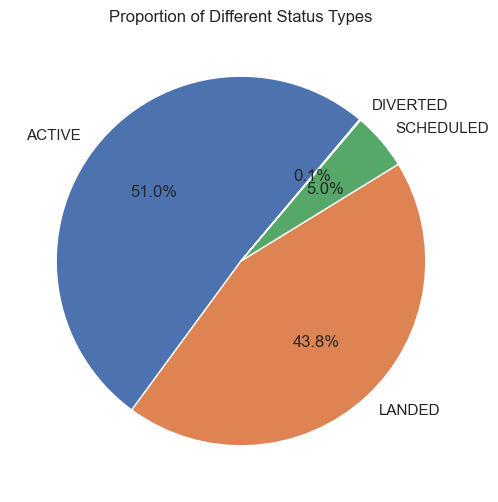

In [9]:
status_summary = flight_performance.get_status_summary()
status_proportions = status_summary['Proportions (%)']  # Extract status proportions for plotting

sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))
plt.pie(status_proportions, labels=status_summary['Status'], autopct='%1.1f%%', startangle=50)
plt.title('Proportion of Different Status Types')
plt.show()

### **3.2. Flight Performance**

Visualize the **distribution** of **delayed flights** across the dataset.
- Histogram for delayed minutes
- Histogram for delayed/not delayed flights

In [10]:
percentages = flight_performance.overall_performance() # Calculate overall performance
print("Overall Flight Performance Percentage\n")
for label, percent in percentages.items():
    print(f"{label}: {percent:.2f}%")

# Define delay ranges and labels
delay_ranges = [
    (0, 60, "0 - 60 minutes"),
    (60, 120, "60 - 120 minutes"),
    (120, 180, "120 - 180 minutes"),
    (180, None, "over 180 minutes")
]

delay_percentages = flight_performance.delayed_flight_percentages(delay_ranges) # Calculate and print delay percentages for each range
print("\nPercentage of Delayed Flights\n")
for label, percent in delay_percentages.items():
    print(f"Between {label}: {percent:.2f}%")

Overall Flight Performance Percentage

Delayed Flights: 61.97%
On-Time Flights: 34.51%
Flights with Missing Status: 3.52%

Percentage of Delayed Flights

Between 0 - 60 minutes: 88.05%
Between 60 - 120 minutes: 5.49%
Between 120 - 180 minutes: 0.79%
Between over 180 minutes: 0.42%


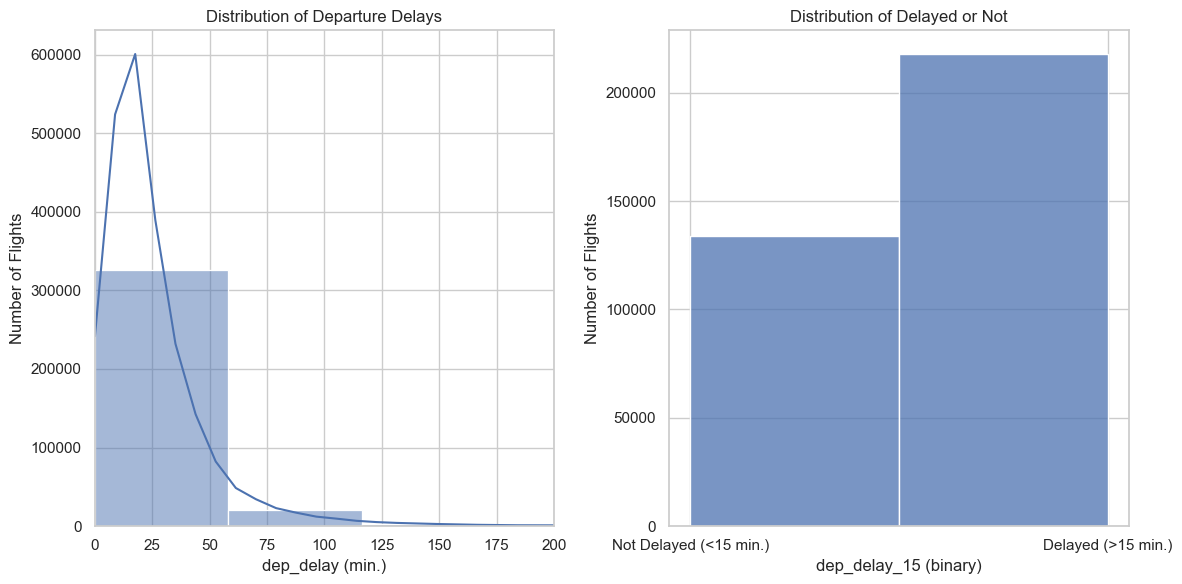

In [11]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1) # Distribution of dep_delay
sns.histplot(df['dep_delay'], bins=30, kde=True)  # kde=True adds a smooth curve
plt.title('Distribution of Departure Delays')
plt.xlabel('dep_delay (min.)')
plt.ylabel('Number of Flights')
plt.xlim(0, 200) 

plt.subplot(1, 2, 2) # Distribution of dep_delay_15 
sns.histplot(df['dep_delay_15'], bins=2, kde=False)  # Binary values (0 and 1)
plt.title('Distribution of Delayed or Not')
plt.xlabel('dep_delay_15 (binary)')
plt.ylabel('Number of Flights')
plt.xticks(ticks=[0, 1], labels=['Not Delayed (<15 min.)', 'Delayed (>15 min.)'])

plt.tight_layout()
plt.show()

### **3.3. Time window**
Understand how flight schedules (departure time sdt and arrival time sat) influence **delays** across different **time windows** (morning, afternoon, night)

In [12]:
dep_flight_summary = flight_performance.flight_summary_by_time_window('dep_time_window', summarize_delays=True)
time_window_proportions = flight_performance.calculate_time_window_percentages()
time_window_proportions

,Departure Percentages (%),Arrival Percentages (%)
Time Window,,
Morning,50.35,40.07
Afternoon,31.26,32.82
Evening,18.39,27.11


In [13]:
dep_flight_summary = flight_performance.flight_summary_by_time_window('dep_time_window', summarize_delays=True)
arr_flight_summary = flight_performance.flight_summary_by_time_window('arr_time_window', summarize_delays=True)
dep_flight_summary

,dep_time_window,total_flights,delayed_flights,dep_time_window_proportion_delayed,dep_time_window_percentage_delayed
0,Afternoon,109932,69602,0.633137,63.31%
1,Evening,64674,40192,0.621455,62.15%
2,Morning,177087,108152,0.610728,61.07%


In [14]:
arr_flight_summary

,arr_time_window,total_flights,delayed_flights,arr_time_window_proportion_delayed,arr_time_window_percentage_delayed
0,Afternoon,115421,75096,0.650627,65.06%
1,Evening,95342,59590,0.625013,62.5%
2,Morning,140930,83260,0.590790,59.08%


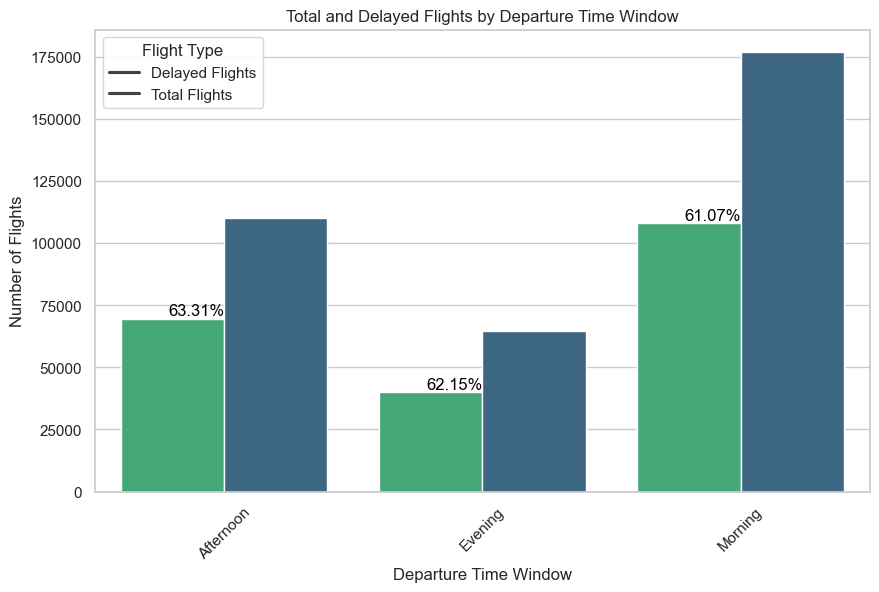

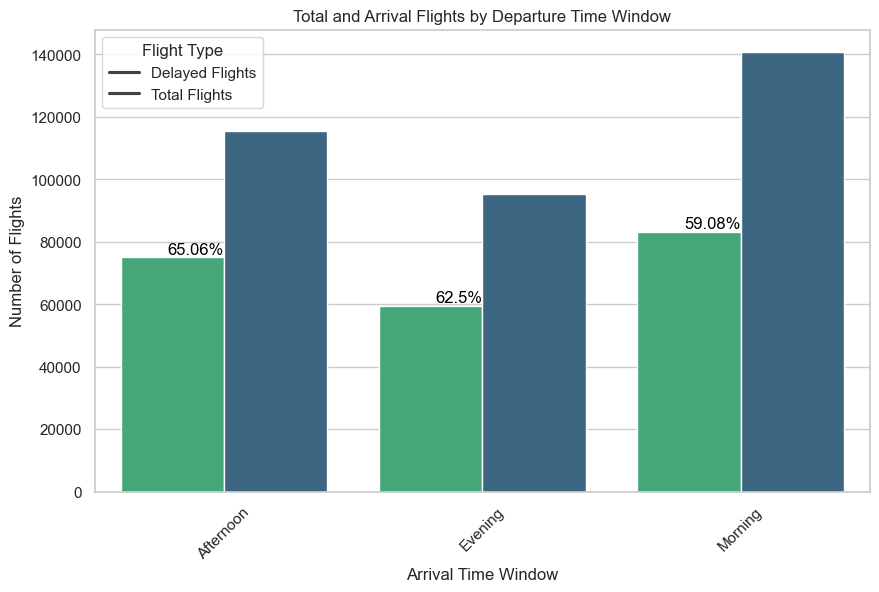

In [15]:
# New df for the bar plots
dep_bar_data = pd.melt(dep_flight_summary, id_vars='dep_time_window', value_vars=['delayed_flights', 'total_flights'],var_name='flight_type', value_name='count')
arr_bar_data = pd.melt(arr_flight_summary, id_vars='arr_time_window', value_vars=['delayed_flights', 'total_flights'],var_name='flight_type', value_name='count')

# Shift left for delayed flights and right for total flights
dep_bar_data['position'] = dep_bar_data['flight_type'].map({'delayed_flights': -0.2, 'total_flights': 0.2})
arr_bar_data['position'] = arr_bar_data['flight_type'].map({'delayed_flights': -0.2, 'total_flights': 0.2})

# Plot for Total and Delayed Arrival Flights
plt.figure(figsize=(10, 6))
ax=sns.barplot(data=dep_bar_data, x='dep_time_window', y='count', hue='flight_type', dodge=True, palette=['#35b779', '#31688e'])
for index, row in dep_flight_summary.iterrows():
    if row['delayed_flights'] > 0:  # Only display if there are delayed flights
        ax.text(index, row['delayed_flights'], f"{row['dep_time_window_percentage_delayed']}", color='black', ha='right', va='bottom', fontsize=12)
plt.title('Total and Delayed Flights by Departure Time Window')
plt.ylabel('Number of Flights')
plt.xlabel('Departure Time Window')
plt.xticks(rotation=45)
plt.legend(title='Flight Type', labels=['Delayed Flights', 'Total Flights'])
plt.show()

# Plot for Total and Delayed Departure Flights
plt.figure(figsize=(10, 6))
bx=sns.barplot(data=arr_bar_data, x='arr_time_window', y='count', hue='flight_type', dodge=True, palette=['#35b779', '#31688e'])
for index, row in arr_flight_summary.iterrows():
    if row['delayed_flights'] > 0:  # Only display if there are delayed flights
        bx.text(index, row['delayed_flights'], f"{row['arr_time_window_percentage_delayed']}", color='black', ha='right', va='bottom', fontsize=12)
plt.title('Total and Arrival Flights by Departure Time Window')
plt.ylabel('Number of Flights')
plt.xlabel('Arrival Time Window')
plt.xticks(rotation=45)
plt.legend(title='Flight Type', labels=['Delayed Flights', 'Total Flights'])
plt.show()

### **3.4. Flight Category Comparison**
Comparison of the **on-time performance** of cargo, private, & commercial flights and the **distribution** of delay times within them.

In [16]:
on_time_performance = flight_performance.calculate_on_time_performance()
flight_percentages = flight_performance.calculate_flight_percentages()

# Combine both DataFrames
combined_performance = pd.merge(on_time_performance, flight_percentages, on='Flight Category', how='left')
combined_performance

,Flight Category,Total Flights,On-Time Performance,Flight Amount Percentage
0,Cargo,20406,31.7%,5.8%
1,Commercial,326405,34.62%,92.81%
2,Private,4882,38.47%,1.39%


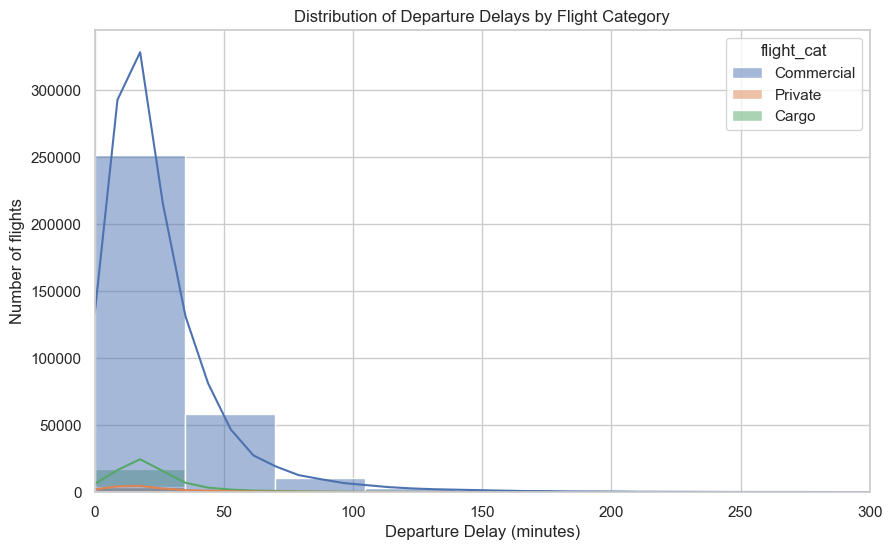

In [17]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='dep_delay', hue='flight_cat', kde=True, bins=50)
plt.xlim(0, 300)  # 300 minutes for better visualization
plt.title('Distribution of Departure Delays by Flight Category')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Number of flights')
plt.show()

### **3.5. Airline Delays**
The total volume of flights and the percentage of delayed flights by airlines.

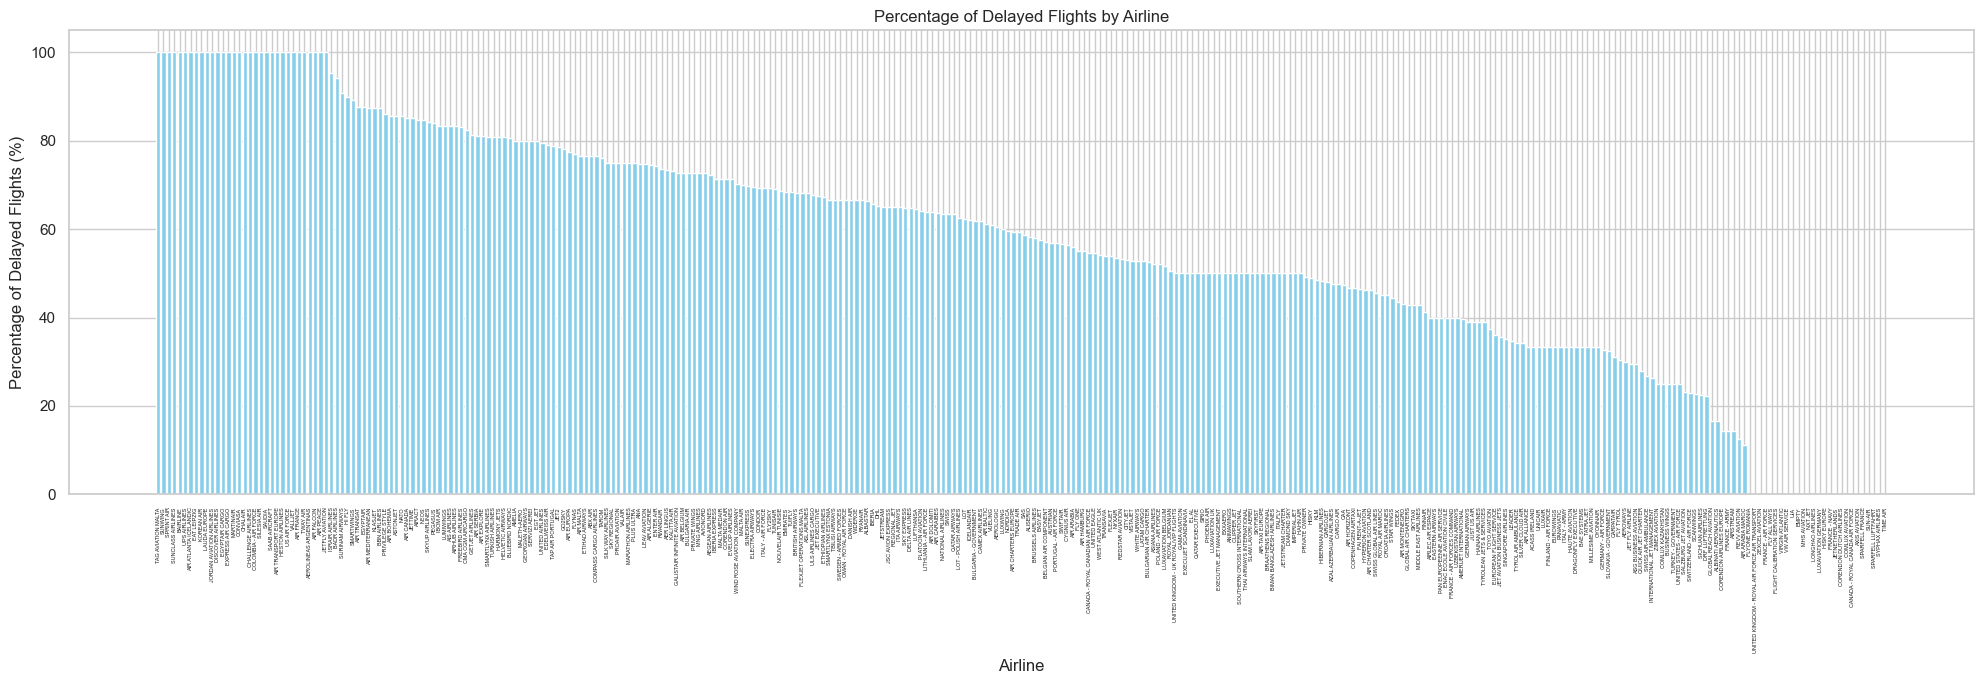

In [18]:
# Total volume of flights by airline
total_flights_airline = df.groupby('airline_name')['uuid'].count().reset_index()
total_flights_airline.columns = ['airline_name', 'total_flights']

# Delayed flights by airline
delayed_flights_airline = df[df['dep_delay_15'] == 1].groupby('airline_name')['uuid'].count().reset_index()
delayed_flights_airline.columns = ['airline_name', 'delayed_flights']

# Percentage of delayed flights
flights_summary = pd.merge(total_flights_airline, delayed_flights_airline, on='airline_name', how='left')
flights_summary['delayed_flights'] = flights_summary['delayed_flights'].fillna(0).astype(int)  # Handling NaNs
flights_summary['percent_delayed(%)'] = ((flights_summary['delayed_flights'] / flights_summary['total_flights']) * 100).round(2)

sorted_flights_summary = flights_summary.sort_values(by='percent_delayed(%)', ascending=False)

sns.set(style="whitegrid")
plt.figure(figsize=(20,7))
plt.bar(sorted_flights_summary['airline_name'], sorted_flights_summary['percent_delayed(%)'], color='skyblue')
plt.xticks(rotation=90, fontsize=4)
plt.xlabel('Airline')
plt.ylabel('Percentage of Delayed Flights (%)')
plt.title('Percentage of Delayed Flights by Airline')
plt.tight_layout()
plt.show()

### **3.6. Frequent Routes and Airports**
Routes and airports in Brussels with the highest percentage of delays.

                  airline_name route_iata_code  average_dep_delay
1136           EVELOP AIRLINES         BRU-VRA             564.00
1731       LUXAVIATION BELGIUM         BOO-BRU             526.00
63            AIR ARABIA MAROC         BRU-FEZ             416.00
905   CORENDON AIRLINES EUROPE         HRG-BRU             340.00
1093        ETHIOPIAN AIRLINES         BRU-JNB             308.22


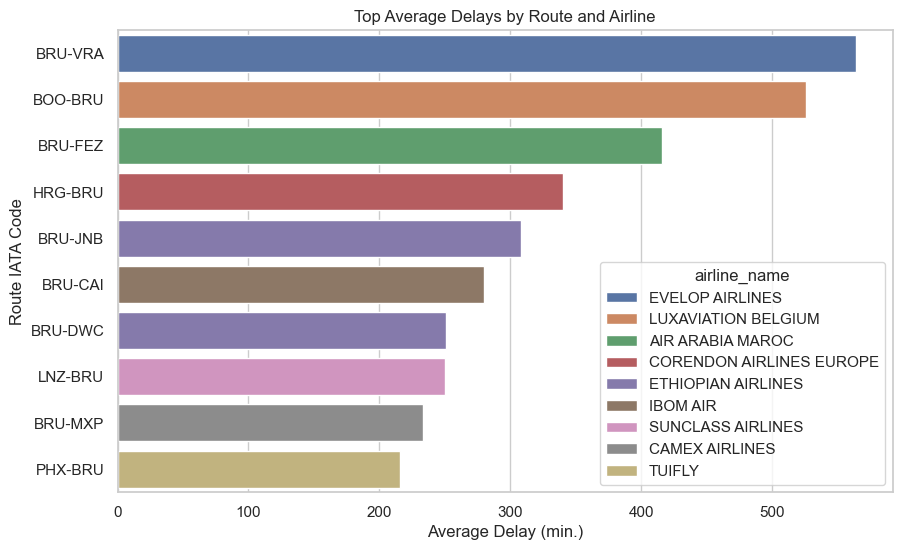

In [19]:
analysis = AirlineDelays(df)

# Calculate and print average delays
average_delay_sorted = analysis.calculate_average_delay()
print(average_delay_sorted.head())
analysis.plot_top_delays(top_n=10) # Plot the top 10 average delays

### **3.7. EDA Results**
1. Most of the flights in the dataset are delayed. **Delayed Flights: 61.97%**
2. Most of the delays happen within the first hour. **Between 0 - 60 minutes: 88.05%**
3. Top 10 airline & route delays
4. Most flights are scheduled to depart in the morning. **Departure (Morning): 50.35%**
5. Most flights are scheduled to arrive in the morning. **Arrival (Morning): 40.07%**
6. The delay within departure flights throughout the day is similar
    * **Afternoon: 63.31%** (of the flights are delayed)
    * Evening: 62.15% 
    * Morning: 61.07% 
7. The delay within arrival flights throughout the day is similar
    * **Afternoon: 65.06%** (of the flights are delayed)
    * Evening: 62.5%
    * Morning: 58.08%
8. Most of the flights are commercial. **Commercial Flights: 92.81%**
9. The delay within departure flight throughout the day is similar
    * Cargo: 31.7%  (of the flights are delayed)
    * Commercial: 34.62%
    * **Private: 38.47%**
10. Most of the flights in the dataset are active. **Active flights: 51.04%**



## **4. Statistical Analysis**

### **4.1. Normality Test**
Many machine learning algorithms, such as linear regression, assume that variables follow a normal distribution. Testing the normality of your data helps determine if transformations are needed before modeling.

* Perform **Shapiro-Wilk Test**: It tests the null hypothesis that the data is normally distributed. If the p-value is less than 0.05, the data significantly deviates from normality. The test will be performed by taking a random sample of the data (5,000 rows) to ensure the test's validity.
* Plot a **Q-Q Plot (Quantile-Quantile plots)**: They compare the data's distribution to a normal distribution. If the data is normally distributed, the points will fall along a straight line.

In [20]:
sample = df['dep_delay'].sample(5000, random_state=42) # Random sample of 5000 rows

# Shapiro-Wilk test
stat, p_value = stats.shapiro(sample)
print(f'Statistic={stat}, p-value={p_value}')
if p_value > 0.05:
    print("Sampled data is normally distributed.")
else:
    print("Sampled data is not normally distributed.")

Statistic=0.4516316919113713, p-value=3.699180439037344e-82
Sampled data is not normally distributed.


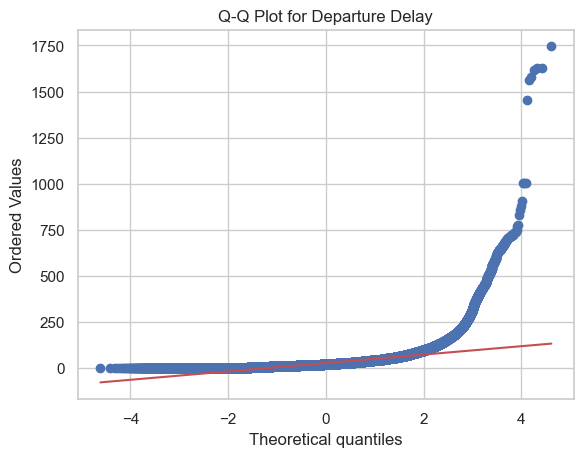

In [21]:
stats.probplot(df['dep_delay'], dist="norm", plot=plt)
plt.title("Q-Q Plot for Departure Delay")
plt.show()

Q-Q plot Results:
* departure delay **deviates** from a theoretical **normal distribution**
* the upward curvature and points far from the red line (which represents a normal distribution) suggest that the data is **not normally distributed**
* the heavy tails (many large values far above the line) indicate **positive skewness** (large number of extreme departure delays)

This means modeling on departure delays may benefit from transformations to normalize the data

### **4.2. Correlation Analysis**
Correlation analysis helps you understand the relationships between numerical variables. This can inform feature selection, detect multicollinearity, and reveal underlying patterns in your data.
* **Correlation Matrix** and **Heatmap**
* **Multicollinearity** Check with **Variance Inflation Factor (VIF)** to quantify how much the variance of each feature is inflated due to multicollinearity
    * A VIF of 1 indicates no correlation between the variable and the other variables.
    * A VIF between 1 and 5 suggests moderate correlation and is usually acceptable.
    * A VIF above 5 (and especially above 10) indicates high multicollinearity that could be problematic. 

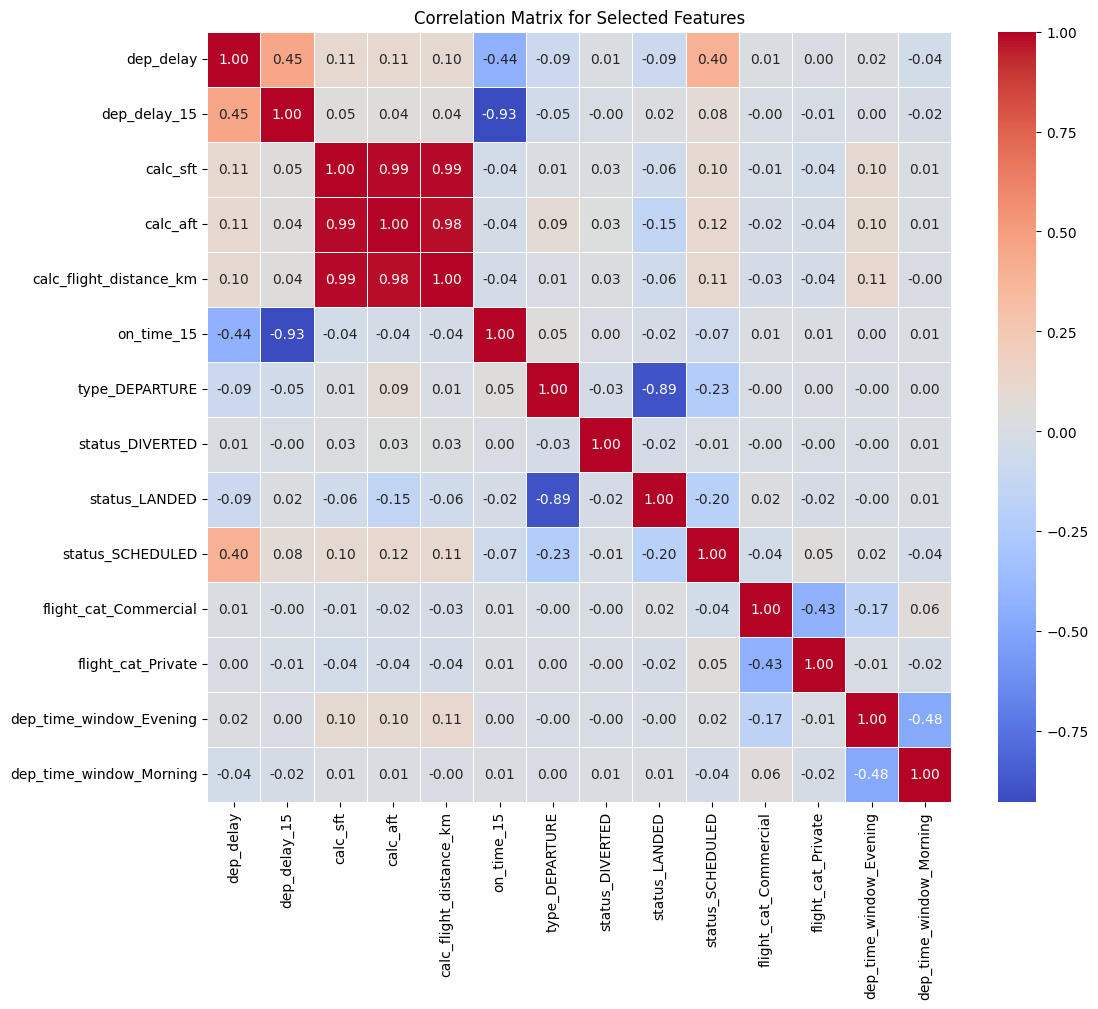

In [10]:
# Select the relevant columns for encoding
columns_of_interest = ['type', 'status', 'flight_cat', 'dep_time_window']

# Filter the DataFrame to include only those columns
df_selected = df[columns_of_interest]

# Apply one-hot encoding to these columns
df_encoded = pd.get_dummies(df_selected, drop_first=True)

# Check for the additional columns in the original DataFrame
additional_columns = ['dep_delay', 'dep_delay_15', 'calc_sft', 'calc_aft', 
                      'calc_flight_distance_km', 'on_time_15']

# Ensure the additional columns exist in the original DataFrame
for col in additional_columns:
    if col not in df.columns:
        print(f"Column '{col}' not found in the original DataFrame.")

# Combine the encoded DataFrame with the additional columns from the original DataFrame
df_combined = pd.concat([df_encoded, df[additional_columns]], axis=1)

# Create a DataFrame with only the selected columns
selected_columns = ['dep_delay', 'dep_delay_15', 'calc_sft', 'calc_aft', 
                    'calc_flight_distance_km', 'on_time_15', 
                    'type_DEPARTURE', 'status_DIVERTED', 'status_LANDED', 
                    'status_SCHEDULED', 'flight_cat_Commercial', 
                    'flight_cat_Private', 'dep_time_window_Evening', 
                    'dep_time_window_Morning']

# Filter the combined DataFrame to include only the selected columns
df_final = df_combined[selected_columns]

# Calculate the correlation matrix for the selected columns
correlation_matrix = df_final.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
plt.title('Correlation Matrix for Selected Features')
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt='.2f', linewidths=0.5)
plt.show()


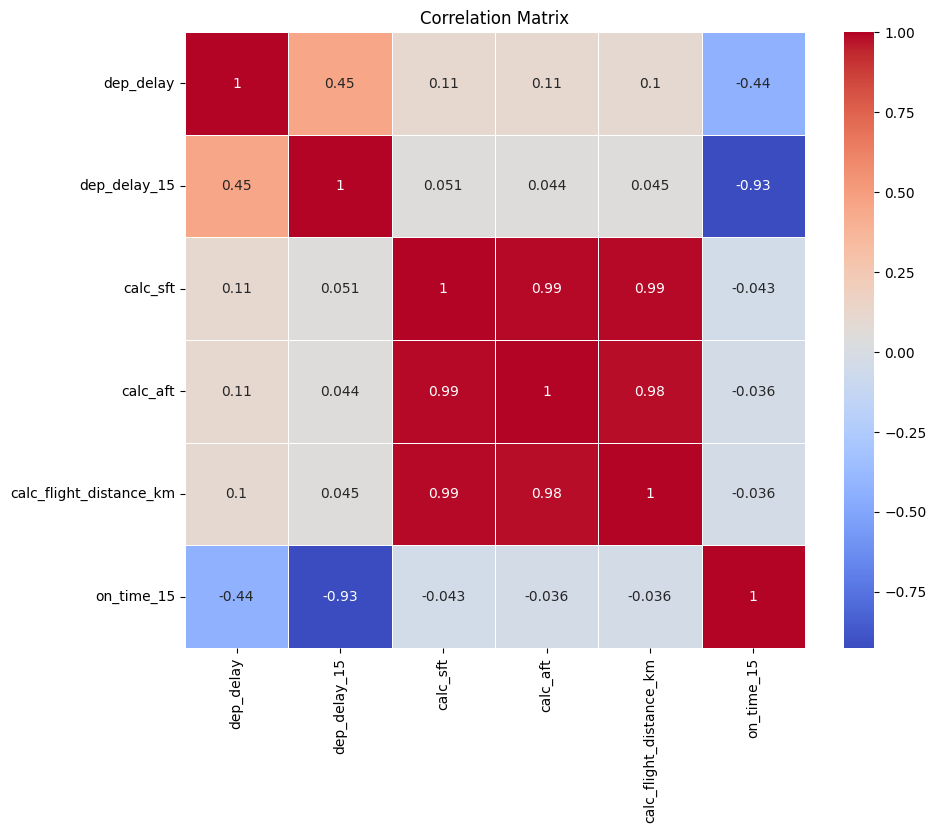

In [12]:
numerical_columns = ['dep_delay', 'dep_delay_15', 'calc_sft', 'calc_aft', 'calc_flight_distance_km','on_time_15'] # Selecting only the numerical columns
corr_matrix = df[numerical_columns].corr() # Creating the correlation matrix

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Correlation Matrix Results:
* **Strong Correlations**
    * There is a very strong positive correlation between the **flight times** (calc_sft, calc_aft), and the **flight distance** (calc_flight_distance_km). This makes sense as longer distances are expected to result in **longer scheduled and actual flight times**.
* **Negative Correlations**
    * Total **departure delay** (dep_delay) and the **flights on time** (on_time_15, marked as on time when it's more than 15 min.) are moderately negatively correlated (-0.44), which is expected because as departure delay increases, the likelihood of a flight being on time decreases.
    * The **departure delay** (dep_delay_15, marked as delayed when it's more than 15 min.) has a very strong negative correlation with the **flights on time** (on_time_15) (-0.93). This indicates a nearly **inverse relationship**: when a flight is delayed by more than 15 minutes, it is almost guaranteed not to be classified as "on time."
* **Weak Correlations**
    * Correlations between **departure dedlays** (dep_delay, dep_delay_15), and the **flight time/distance-related features** (calc_sft, calc_aft, calc_flight_distance_km) are weak, which means that **flight time** or **distance** does not significantly impact the likelihood of **departure delays** in this dataset.

In [13]:
X = df[['calc_sft', 'calc_aft', 'calc_flight_distance_km', 'dep_delay', 'dep_delay_15', 'on_time_15']] # Select relevant features for VIF calculation

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns # Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

                   feature         VIF
0                 calc_sft  190.967151
1                 calc_aft  146.052298
2  calc_flight_distance_km   76.839313
3                dep_delay    2.217180
4             dep_delay_15    4.825181
5               on_time_15    2.498786


* calc_sft and calc_aft have **extremely high** VIF values (>10), indicating high multicollinearity.
* calc_flight_distance_km also shows **significant multicollinearity** with a VIF of 76.84.
* The **other variables** seem **fine** as their VIF values are below 5, which is typically an acceptable threshold for multicollinearity.

In [14]:
features = ['dep_delay', 'dep_delay_15', 'on_time_15']
x = df[features] # New dataframe with the selected features
x = sm.add_constant(x) # Add a constant term for the intercept

# Function to calculate VIF
def calculate_vif(x):
    vif_data = pd.DataFrame()
    vif_data['feature'] = x.columns
    vif_data['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    return vif_data

vif_initial = calculate_vif(x)# Calculate initial VIF
print("Initial VIF:")
print(vif_initial)

x_reduced = df[['dep_delay', 'on_time_15']]  # If high VIFs, remove one of the  features
x_reduced = sm.add_constant(x_reduced) # Add a constant term again

vif_reduced = calculate_vif(x_reduced) # Recalculate VIF
print("\nReduced VIF after removing dep_delay_15:")
print(vif_reduced)

model = sm.OLS(df['dep_delay_15'], x_reduced).fit()  # Fit the updated model with your actual dependent variable
print("\nModel Summary:")
print(model.summary())

Initial VIF:
        feature        VIF
0         const  28.679873
1     dep_delay   1.261594
2  dep_delay_15   7.224768
3    on_time_15   7.082597

Reduced VIF after removing dep_delay_15:
      feature       VIF
0       const  3.240753
1   dep_delay  1.234167
2  on_time_15  1.234167

Model Summary:
                            OLS Regression Results                            
Dep. Variable:           dep_delay_15   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                 1.095e+06
Date:                Tue, 15 Oct 2024   Prob (F-statistic):               0.00
Time:                        15:47:14   Log-Likelihood:             1.0286e+05
No. Observations:              351693   AIC:                        -2.057e+05
Df Residuals:                  351690   BIC:                        -2.057e+05
Df Model:                           2                             

* Const in Linear Models: The constant term represents the expected value of the dependent variable when all predictor variables are zero.
* High VIF for the Constant: A high VIF for the constant can be indicative of a design matrix that lacks variance or is poorly scaled. However, it does not necessarily mean that the model is problematic. It primarily reflects the overall correlation structure of the data.

### **4.3. Statistical Test**

In [26]:
observed_counts = [flight_performance.count_delayed_flights(lower, upper) for lower, upper, _ in delay_ranges] # Observed counts of delayed flights in each range
total_observed_counts = sum(observed_counts) # Calculate the total observed counts

if total_observed_counts == 0:
    print("No delayed flights were observed. Cannot perform chi-squared test.")
else:
    expected_counts = [total_observed_counts / len(delay_ranges)] * len(delay_ranges) # Expected counts: Equal distribution across ranges based on observed counts
    chi2_stat, p_value = stats.chisquare(f_obs=observed_counts, f_exp=expected_counts) # Perform the chi-squared test

    print(f"Chi-squared Statistic: {chi2_stat:.4f}")
    print(f"P-value: {p_value:.4f}")

    if p_value < 0.05:
        print("The differences in delay ranges are statistically significant (p < 0.05).")
    else:
        print("The differences in delay ranges are not statistically significant (p ≥ 0.05).")

Chi-squared Statistic: 822336.7532
P-value: 0.0000
The differences in delay ranges are statistically significant (p < 0.05).


Interpretation of Results:
* **Chi-squared Statistic** (822336.7532): This value indicates the degree of deviation between the observed frequencies (actual counts of delayed flights in each range) and the expected frequencies (counts predicted based on the hypothesis). A high chi-squared statistic typically suggests a **large difference** between observed and expected values.

* **P-value** (0.0000): A p-value of 0.0000 (which is effectively less than 0.05) indicates that the likelihood of observing such a large chi-squared statistic due to random chance is **extremely low**. Therefore, you can **reject the null hypothesis** that there is no significant difference in the distributions of delayed flights across the defined ranges.

* **Statistical Significance**: Since the differences in delay ranges are statistically significant, this means that the **distribution of delayed flight**s across the delay categories is not uniform and that there are significant variations in how flights are delayed.

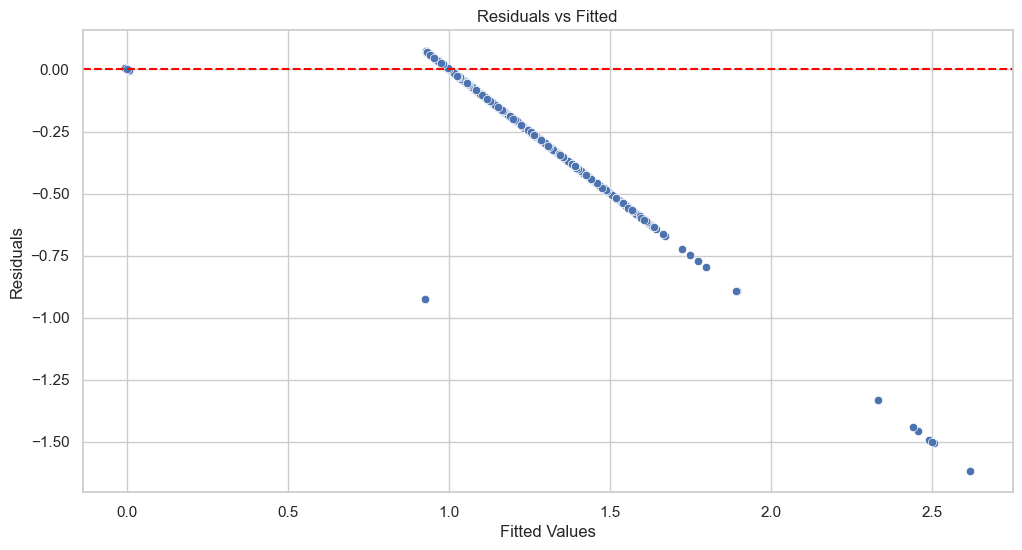

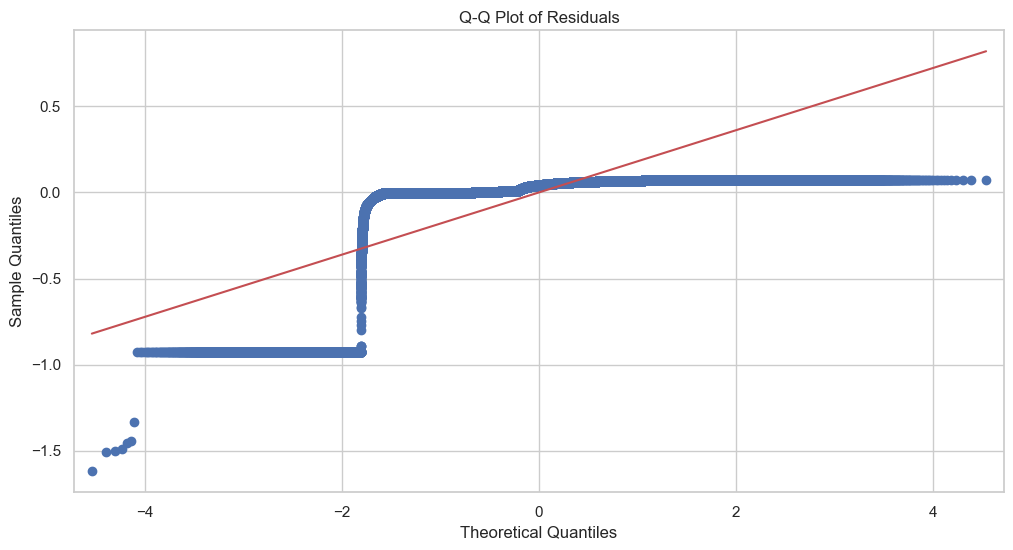

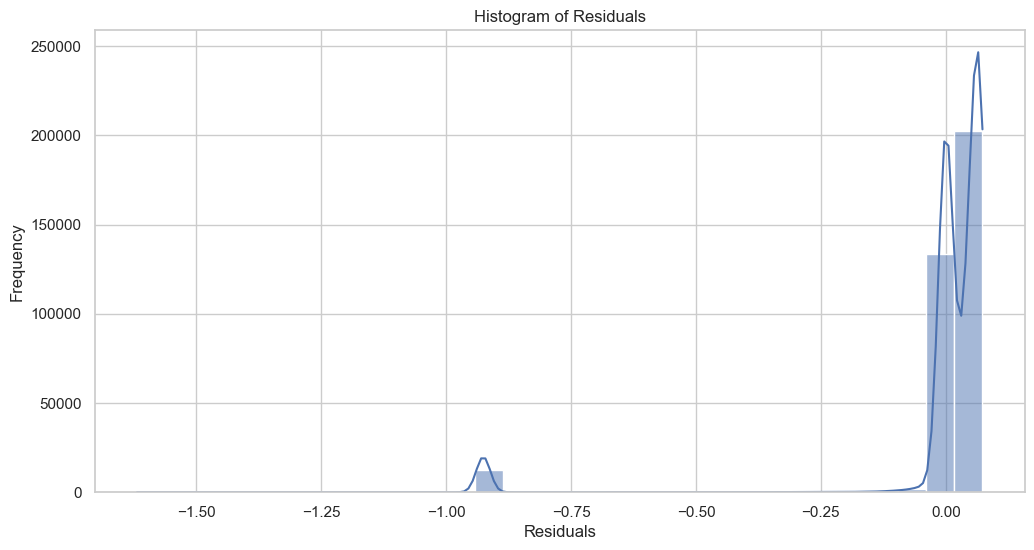


Shapiro-Wilk Test: Statistic=0.3191751247261424, p-value=2.6269886177913144e-203

Durbin-Watson statistic: 1.9586651609483798
Residuals are not normally distributed (reject H0).
No autocorrelation (DW between 1.5 and 2.5).


C:\Testing\Anaconda\envs\DTCS\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 351693.
  res = hypotest_fun_out(*samples, **kwds)


In [27]:
# Residual Analysis
residuals = model.resid
fitted = model.fittedvalues # Extract residuals and fitted values
plt.figure(figsize=(12, 6))
sns.scatterplot(x=fitted, y=residuals)
plt.axhline(0, linestyle='--', color='red')
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# Q-Q Plot for Normality
plt.figure(figsize=(12, 6))
sm.qqplot(residuals, line='s', ax=plt.gca())
plt.title('Q-Q Plot of Residuals')
plt.show()

# Histogram of Residuals
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

shapiro_test = stats.shapiro(residuals) # Shapiro-Wilk Test for Normality
print(f"\nShapiro-Wilk Test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")

# Durbin-Watson Test for Autocorrelation
dw_statistic = durbin_watson(residuals)
print(f"\nDurbin-Watson statistic: {dw_statistic}")

# Interpretation of tests
if shapiro_test.pvalue < 0.05:
    print("Residuals are not normally distributed (reject H0).")
else:
    print("Residuals are normally distributed (fail to reject H0).")

if dw_statistic < 1.5:
    print("Positive autocorrelation (DW < 1.5).")
elif dw_statistic > 2.5:
    print("Negative autocorrelation (DW > 2.5).")
else:
    print("No autocorrelation (DW between 1.5 and 2.5).")

## **5. Modelling (Next step)**